# Twitter Sentiment Analysis

## 1.Importing the necessary libraries

In [1]:
import pandas as pd
from pandas import read_excel
import numpy as np
import re
from re import sub
import multiprocessing
from unidecode import unidecode
import os
from time import time 
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import LSTM,Dense,Dropout,Activation,Embedding,Flatten,Bidirectional,MaxPooling2D, Conv1D, MaxPooling1D
from tensorflow.keras.optimizers import SGD,Adam
from keras import regularizers
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils.np_utils import to_categorical
import h5py
import csv
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords



## 2.Load the Data Set

In [2]:

data=pd.read_csv('Tweets2.csv')
data.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## 3.EDA

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14640 entries, 0 to 14639
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   tweet_id                      14640 non-null  int64  
 1   airline_sentiment             14640 non-null  object 
 2   airline_sentiment_confidence  14640 non-null  float64
 3   negativereason                9178 non-null   object 
 4   negativereason_confidence     10522 non-null  float64
 5   airline                       14640 non-null  object 
 6   airline_sentiment_gold        40 non-null     object 
 7   name                          14640 non-null  object 
 8   negativereason_gold           32 non-null     object 
 9   retweet_count                 14640 non-null  int64  
 10  text                          14640 non-null  object 
 11  tweet_coord                   1019 non-null   object 
 12  tweet_created                 14640 non-null  object 
 13  t

In [4]:
list(data.columns.values)

['tweet_id',
 'airline_sentiment',
 'airline_sentiment_confidence',
 'negativereason',
 'negativereason_confidence',
 'airline',
 'airline_sentiment_gold',
 'name',
 'negativereason_gold',
 'retweet_count',
 'text',
 'tweet_coord',
 'tweet_created',
 'tweet_location',
 'user_timezone']

In [5]:
data.shape

(14640, 15)

In [6]:
data.count()


tweet_id                        14640
airline_sentiment               14640
airline_sentiment_confidence    14640
negativereason                   9178
negativereason_confidence       10522
airline                         14640
airline_sentiment_gold             40
name                            14640
negativereason_gold                32
retweet_count                   14640
text                            14640
tweet_coord                      1019
tweet_created                   14640
tweet_location                   9907
user_timezone                    9820
dtype: int64

In [7]:
data.dtypes

tweet_id                          int64
airline_sentiment                object
airline_sentiment_confidence    float64
negativereason                   object
negativereason_confidence       float64
airline                          object
airline_sentiment_gold           object
name                             object
negativereason_gold              object
retweet_count                     int64
text                             object
tweet_coord                      object
tweet_created                    object
tweet_location                   object
user_timezone                    object
dtype: object

## Total count per Airlines

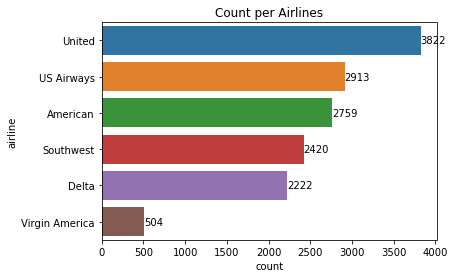

In [8]:
ax = sns.countplot(data = data, y = 'airline',
                   order = data.airline.value_counts().index)
ax.bar_label(ax.containers[0])
ax.set_title('Count per Airlines',)
                                    
plt.show()

## Proportion of Sentiments¶


In [9]:
temp = data.groupby('airline_sentiment').count()['text'].reset_index().sort_values(by='text',ascending=False)
temp.style.background_gradient(cmap='Purples')

,airline_sentiment,text
0,negative,9178
1,neutral,3099
2,positive,2363


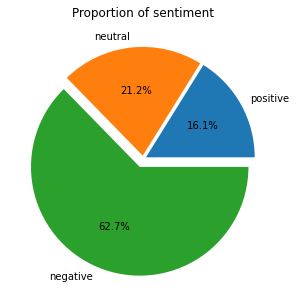

In [10]:
x = data.airline_sentiment.value_counts().sort_values()

plt.figure(figsize=(5, 5))
ax = plt.pie(x = x, labels=x.index, autopct = '%1.1f%%', explode = [0.03, 0.03, 0.08])
plt.title('Proportion of sentiment')

plt.show()

In [11]:
a = data.groupby(['airline', 'airline_sentiment'])['airline_sentiment'].count().unstack()
#a['total'] =  [a.values[x].sum() for x in range(0,6)]
a

airline_sentiment,negative,neutral,positive
airline,,,
American,1960,463,336
Delta,955,723,544
Southwest,1186,664,570
US Airways,2263,381,269
United,2633,697,492
Virgin America,181,171,152


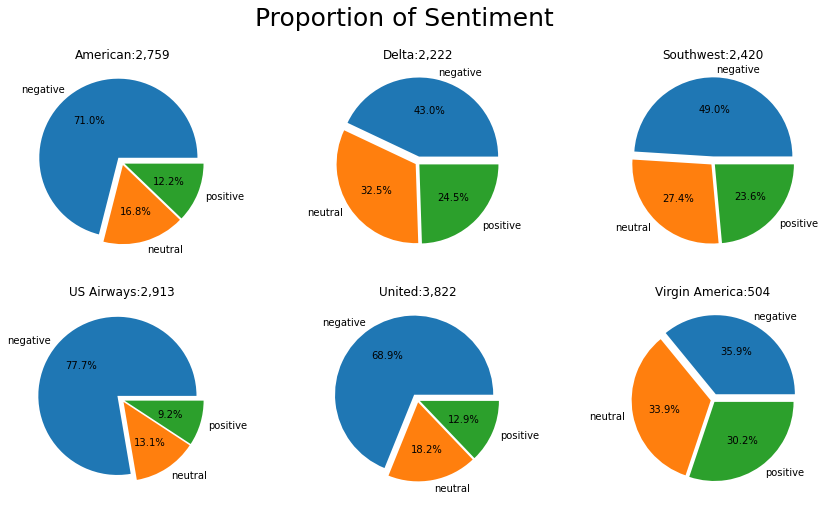

In [12]:
fig, axes = plt.subplots(2, 3, figsize = (15, 8))
axes = axes.flatten()
for i, ax in zip(range(0, 6), axes):
    temp = a.iloc[i]    
    ax.pie(x = temp, labels = temp.index, autopct = '%1.1f%%', explode = [0.08, 0.03, 0.03])
    ax.set_title(f"{a.index[i]}:{format(a.values[i].sum(),',')}")

plt.suptitle("Proportion of Sentiment", fontsize = 25)    
plt.show()

#################################################################
##########################################
####################################
#####################################

## Reason for Negative sentiment

In [13]:
print(data.negativereason.unique())

[nan 'Bad Flight' "Can't Tell" 'Late Flight' 'Customer Service Issue'
 'Flight Booking Problems' 'Lost Luggage' 'Flight Attendant Complaints'
 'Cancelled Flight' 'Damaged Luggage' 'longlines']


In [14]:
df_neg = data[data.airline_sentiment == 'negative']
display(df_neg.shape, df_neg.head())

(9178, 15)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)
5,570300767074181121,negative,1.0000,Can't Tell,0.6842,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica seriously would pay $30 a fligh...,NaN,2015-02-24 11:14:33 -0800,NaN,Pacific Time (US & Canada)
15,570282469121007616,negative,0.6842,Late Flight,0.3684,Virgin America,NaN,smartwatermelon,NaN,0,@VirginAmerica SFO-PDX schedule is still MIA.,NaN,2015-02-24 10:01:50 -0800,"palo alto, ca",Pacific Time (US & Canada)
17,570276917301137409,negative,1.0000,Bad Flight,1.0000,Virgin America,NaN,heatherovieda,NaN,0,@VirginAmerica I flew from NYC to SFO last we...,NaN,2015-02-24 09:39:46 -0800,this place called NYC,Eastern Time (US & Canada)


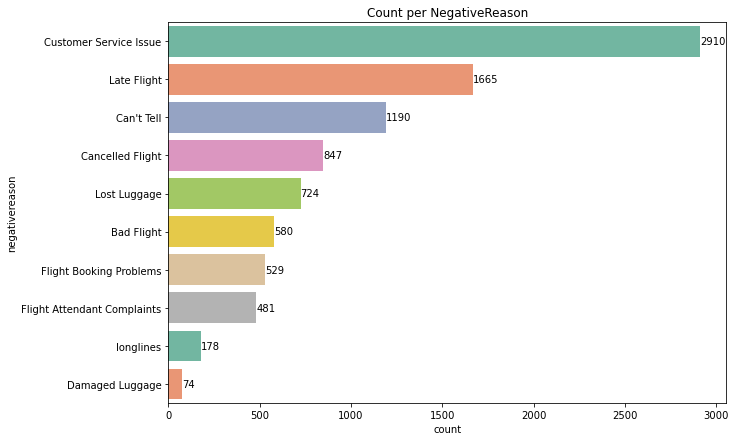

In [15]:
plt.figure(figsize=(10,7))
ax = sns.countplot(data = df_neg, y = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index)

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')

plt.show()

Customer service issue, as a whole, is the main reason for the negative sentiment to the airlines.

The following is the detail sorted by airlines' name.

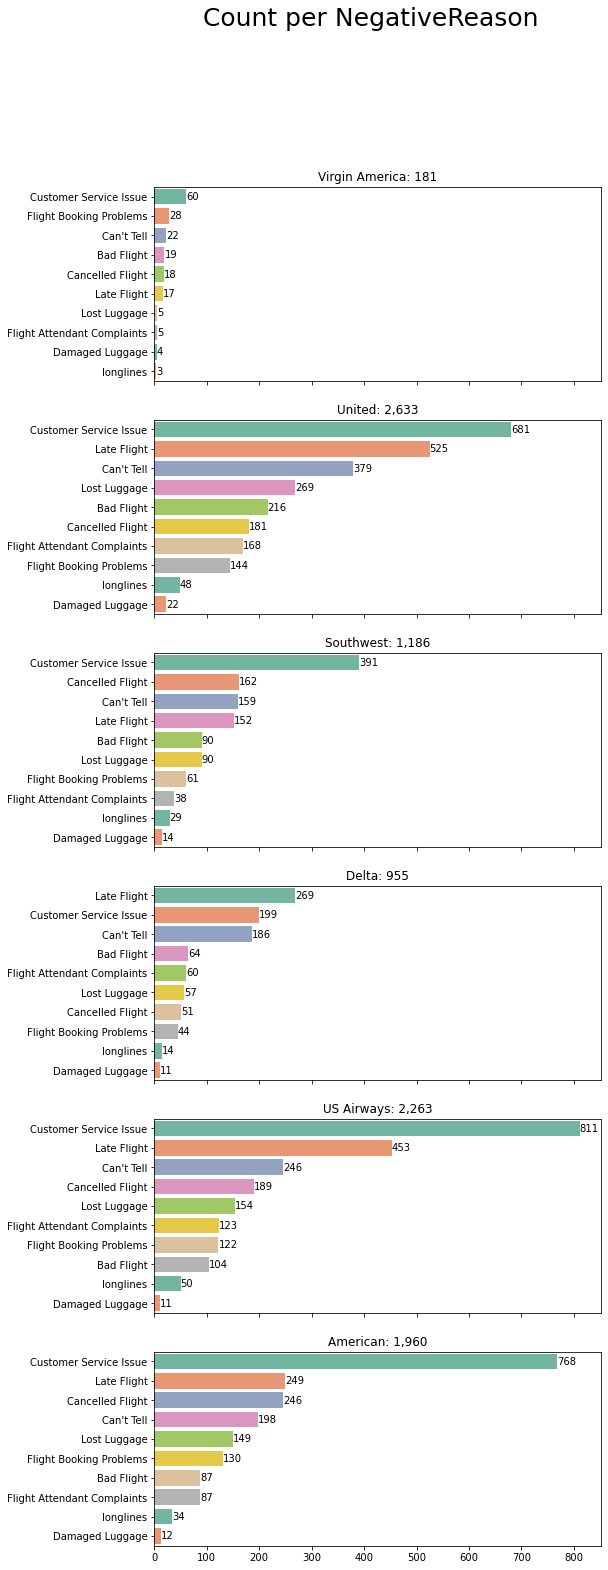

In [16]:
fig, axes = plt.subplots(6, 1, figsize=(8, 25), sharex=True)
axes = axes.flatten()
names = df_neg['airline'].unique()

for name, n in zip(names, axes):
    ax = sns.countplot(data = df_neg[df_neg.airline==name], y = 'negativereason',
                       palette='Set2',
                       order = df_neg[df_neg.airline==name].negativereason.value_counts().index, ax = n)
    ax.bar_label(ax.containers[0])
    ax.set_title(f"{name}: {format(len(df_neg[df_neg.airline==name]),',')}")
    ax.set_xlabel('')
    ax.set_ylabel('')

plt.suptitle("Count per NegativeReason", fontsize = 25)
plt.show()

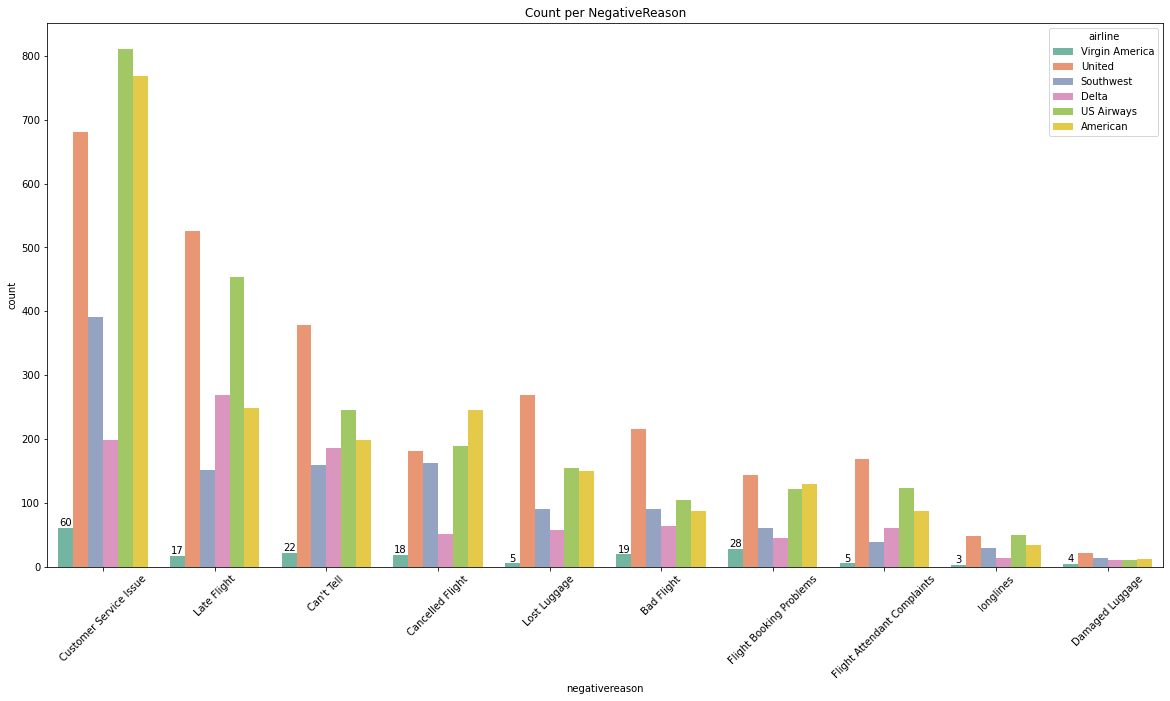

In [17]:
plt.figure(figsize=(20,10))
ax = sns.countplot(data = df_neg, x = 'negativereason',
                   palette='Set2',
                   order = df_neg.negativereason.value_counts().index, hue = 'airline')

ax.bar_label(ax.containers[0])
ax.set_title('Count per NegativeReason')
plt.xticks(rotation=45)
plt.show()

In [18]:
names = data.airline.unique()
for name in names:
    print(f"{name} : Out of total {format(len(data[data.airline == name]),',')}customers, {(len(df_neg[df_neg.airline == name]) / len(data[data.airline == name]))*100:.1f}% feel negative.\n")

Virgin America : Out of total 504customers, 35.9% feel negative.

United : Out of total 3,822customers, 68.9% feel negative.

Southwest : Out of total 2,420customers, 49.0% feel negative.

Delta : Out of total 2,222customers, 43.0% feel negative.

US Airways : Out of total 2,913customers, 77.7% feel negative.

American : Out of total 2,759customers, 71.0% feel negative.



## Text Preprocessing

C:\Users\ethernet\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


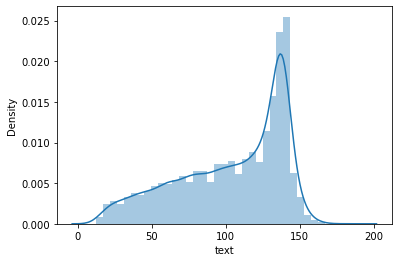

In [19]:
sns.distplot(data.text.str.len())

plt.show()

In [20]:
data.text.str.len().describe()

count    14640.000000
mean       103.822063
std         36.277339
min         12.000000
25%         77.000000
50%        114.000000
75%        136.000000
max        186.000000
Name: text, dtype: float64

Tweet text is consisted of 103 length in average.

Minimum length is 12, and maximum one is 186.

In [21]:
df=pd.read_csv('Tweets2.csv')
df = df[["airline_sentiment","text"]]
df

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...
...,...,...
14635,positive,@AmericanAir thank you we got on a different f...
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...
14637,neutral,@AmericanAir Please bring American Airlines to...
14638,negative,"@AmericanAir you have my money, you change my ..."


In [22]:
new_clom=[]
#def clean_tweets(df):
    
for t in df['text'] :
        result = re.sub(r"http\S+", "", t) #clean links
        tweet = re.sub(r'\@\w+', ' ', result) # clean hachtags
        x = re.sub('[^A-Za-z]', ' ', tweet.lower()) #clean all except alphbitc
        reusfinal=re.sub(' +', ' ', x)
        new_clom.append(reusfinal)  
        #tweetIndex = t.find('https://t.co')
        #print(t)
        #print(z)
        #print("-------------------------------------------")
        #print(tweetIndex)
    
                       
df['cleanTweet'] = new_clom

In [23]:
import spacy

stop = stopwords.words('english')
df['cleanTweet'] = df['cleanTweet'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

def space(comment):
    doc = nlp(comment)
    return " ".join([token.lemma_ for token in doc])
df['cleanTweet']= df['cleanTweet'].apply(space)



In [24]:
df


,airline_sentiment,text,cleanTweet
0,neutral,@VirginAmerica What @dhepburn said.,say
1,positive,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing
...,...,...,...
14635,positive,@AmericanAir thank you we got on a different f...,thank get different flight chicago
14636,negative,@AmericanAir leaving over 20 minutes Late Flig...,leave minute late flight warning communication...
14637,neutral,@AmericanAir Please bring American Airlines to...,please bring american airline blackberry
14638,negative,"@AmericanAir you have my money, you change my ...",money change flight answer phone suggestion ma...


In [25]:
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="neutral", value=2)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="positive", value=1)
df["airline_sentiment"] = df["airline_sentiment"].replace(regex="negative", value=0)
df


,airline_sentiment,text,cleanTweet
0,2,@VirginAmerica What @dhepburn said.,say
1,1,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
2,2,@VirginAmerica I didn't today... Must mean I n...,today must mean need take another trip
3,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
...,...,...,...
14635,1,@AmericanAir thank you we got on a different f...,thank get different flight chicago
14636,0,@AmericanAir leaving over 20 minutes Late Flig...,leave minute late flight warning communication...
14637,2,@AmericanAir Please bring American Airlines to...,please bring american airline blackberry
14638,0,"@AmericanAir you have my money, you change my ...",money change flight answer phone suggestion ma...


In [26]:
df.drop(df.index[df['airline_sentiment'] == 2], inplace=True)
df


,airline_sentiment,text,cleanTweet
1,1,@VirginAmerica plus you've added commercials t...,plus add commercial experience tacky
3,0,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,0,@VirginAmerica and it's a really big bad thing...,really big bad thing
5,0,@VirginAmerica seriously would pay $30 a fligh...,seriously would pay flight seat play really ba...
6,1,"@VirginAmerica yes, nearly every time I fly VX...",yes nearly every time fly vx ear worm go away
...,...,...,...
14633,0,@AmericanAir my flight was Cancelled Flightled...,flight cancel flightle leave tomorrow morning ...
14634,0,@AmericanAir right on cue with the delays👌,right cue delay
14635,1,@AmericanAir thank you we got on a different f...,thank get different flight chicago
14636,0,@AmericanAir leaving over 20 minutes Late Flig...,leave minute late flight warning communication...


In [27]:
train1, test1 = train_test_split(df,random_state=69, test_size=0.2)
training_sentences = []
testing_sentences = []



train_sentences=train1['cleanTweet'].values
train_labels=train1['airline_sentiment'].values
for i in range(train_sentences.shape[0]): 
    #print(train_sentences[i])
    x=str(train_sentences[i])
    training_sentences.append(x)
    
training_sentences=np.array(training_sentences)





test_sentences=test1['cleanTweet'].values
test_labels=test1['airline_sentiment'].values

for i in range(test_sentences.shape[0]): 
    x=str(test_sentences[i])
    testing_sentences.append(x)
    
testing_sentences=np.array(testing_sentences)


train_labels=keras.utils.np_utils.to_categorical(train_labels)


test_labels=keras.utils.np_utils.to_categorical(test_labels)
print("Training Set Length: "+str(len(train1)))
print("Testing Set Length: "+str(len(test1)))
print("training_sentences shape: "+str(training_sentences.shape))
print("testing_sentences shape: "+str(testing_sentences.shape))
print("train_labels shape: "+str(train_labels.shape))
print("test_labels shape: "+str(test_labels.shape))


Training Set Length: 9232
Testing Set Length: 2309
training_sentences shape: (9232,)
testing_sentences shape: (2309,)
train_labels shape: (9232, 2)
test_labels shape: (2309, 2)


In [28]:
print(training_sentences[6])
print(train_labels[1])


bad minute delay boston weather relate flightd go miss connect flight gas plane issue
[1. 0.]


In [29]:
vocab_size = 25000
embedding_dim = 300
max_length = 100
trunc_type='post'
oov_tok = "<OOV>"

In [30]:
tokenizer = Tokenizer(num_words = vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index
print(len(word_index))
print("Word index length:"+str(len(tokenizer.word_index)))
sequences = tokenizer.texts_to_sequences(training_sentences)
padded = pad_sequences(sequences,maxlen=max_length, truncating=trunc_type)


test_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(test_sequences,maxlen=max_length)

7214
Word index length:7214


In [31]:
print("Sentence :--> \n")
print(training_sentences[6]+"\n")
print("Sentence Tokenized and Converted into Sequence :--> \n")
print(str(sequences[6])+"\n")
print("After Padding the Sequence with padding length 100 :--> \n")
print(padded[6])

Sentence :--> 

bad minute delay boston weather relate flightd go miss connect flight gas plane issue

Sentence Tokenized and Converted into Sequence :--> 

[31, 50, 8, 297, 76, 875, 669, 17, 40, 187, 2, 1539, 15, 67]

After Padding the Sequence with padding length 100 :--> 

[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0   31   50    8  297   76  875  669   17   40  187    2 1539
   15   67]


In [32]:
print("Padded shape(training): "+str(padded.shape))
print("Padded shape(testing): "+str(testing_padded.shape))

Padded shape(training): (9232, 100)
Padded shape(testing): (2309, 100)


In [34]:
with tf.device('/gpu:0'):
    model= Sequential()
    model.add(Embedding(vocab_size, embedding_dim, input_length=max_length))
    model.add(Conv1D(200, kernel_size=3, activation = "relu"))
    model.add(Bidirectional(LSTM(64, return_sequences=True)))
    model.add(Dropout(0.2))
    model.add(Bidirectional(LSTM(64)))
    model.add(Dense(50, activation='relu'))
    model.add(Flatten())
    #l2 regularizer
    model.add(Dense(100,kernel_regularizer=regularizers.l2(0.01),activation="relu"))
    model.add(Dense(2, activation='softmax'))
    #sgd= SGD(lr=0.0001,decay=1e-6,momentum=0.9,nesterov=True)
    adam=Adam(learning_rate=0.0005,beta_1=0.9,beta_2=0.999,epsilon=1e-07,amsgrad=False)
    model.summary()
    model.compile(loss='categorical_crossentropy',optimizer=adam,metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 100, 300)          7500000   
_________________________________________________________________
conv1d (Conv1D)              (None, 98, 200)           180200    
_________________________________________________________________
bidirectional (Bidirectional (None, 98, 128)           135680    
_________________________________________________________________
dropout (Dropout)            (None, 98, 128)           0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 128)               98816     
_________________________________________________________________
dense (Dense)                (None, 50)                6450      
_________________________________________________________________
flatten (Flatten)            (None, 50)                0

In [35]:
history=model.fit(padded,train_labels,epochs=5,batch_size=256,validation_data=(testing_padded,test_labels),use_multiprocessing=True, workers=8)

Epoch 1/5
37/37 [==============================] - 40s 871ms/step - loss: 1.1206 - accuracy: 0.7919 - val_loss: 0.9195 - val_accuracy: 0.8086
Epoch 2/5
37/37 [==============================] - 32s 859ms/step - loss: 0.7572 - accuracy: 0.8750 - val_loss: 0.6293 - val_accuracy: 0.9117
Epoch 3/5
37/37 [==============================] - 32s 879ms/step - loss: 0.5071 - accuracy: 0.9454 - val_loss: 0.5372 - val_accuracy: 0.9112
Epoch 4/5
37/37 [==============================] - 32s 877ms/step - loss: 0.3795 - accuracy: 0.9667 - val_loss: 0.4794 - val_accuracy: 0.9134
Epoch 5/5
37/37 [==============================] - 33s 887ms/step - loss: 0.2884 - accuracy: 0.9737 - val_loss: 0.4441 - val_accuracy: 0.9151


dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


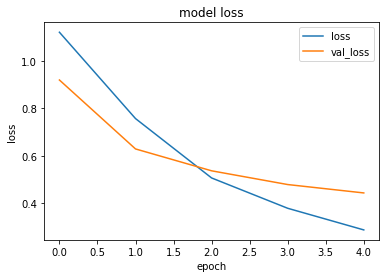

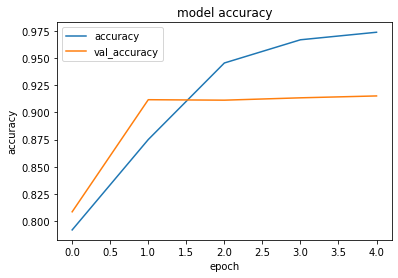

In [36]:
print(history.history.keys())
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.plot(loss)
plt.plot(val_loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['loss', 'val_loss'])
plt.show()

accuracy = history.history['accuracy']
val_accuracy= history.history['val_accuracy']
plt.plot(accuracy)
plt.plot(val_accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['accuracy', 'val_accuracy'])
plt.show()

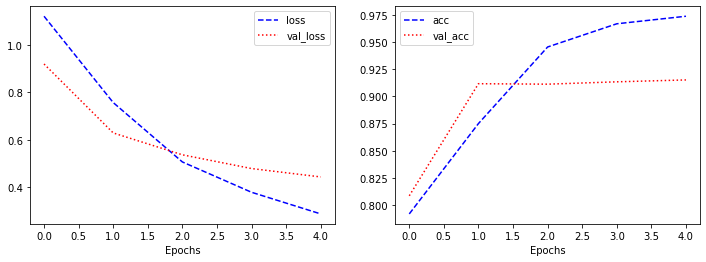

In [37]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], 'b--', label = 'loss')
plt.plot(history.history['val_loss'], 'r:', label = 'val_loss')
plt.xlabel('Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], 'b--', label = 'acc')
plt.plot(history.history['val_accuracy'], 'r:', label = 'val_acc')
plt.xlabel('Epochs')
plt.legend()

plt.show()

In [ ]:
model.save('cnn_lstm.h5')


In [ ]:
from keras.models import load_model
model = models.load_model('cnn_lstm.h5')

In [ ]:
test_sentence1 = [ "really big bad thing"]


#Converting the sentences to sequences using a tokenizer
test_sequences1 = tokenizer.texts_to_sequences(test_sentence1)

#Padding the new sequences to make them have the same dimension
test_padded1 = pad_sequences(test_sequences1, maxlen = 25000, 
                             padding = 'post')

#Testing out the new padded data on a trained LSTM-SVM model
test_padded1 = np.array(test_padded1)
print(model.predict(test_padded1))